# The instability of numerical codes: symptoms

In [3]:
import numpy as np
from nm_lib import nm_lib as nm
import threading

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

db = np.float64

In [4]:
def u(x):
    """
    u(x) function from eq. (2)"""
    return np.cos(db(6)*np.pi*x/db(5))**2/(np.cosh(db(5)*x**2))

def shift_xx(xx, a, t, xf, x0):
    #let x-grid move with velocity a to the side and wrap around to other side
    #takes in the velocity a and the current time t. And end of grid xf and start x0
    xx_new = ((xx - a * t) - x0) % (xf - x0) + x0
    return xx_new

The instability of numerical schemes and codes is one of the critical problems that a researcher using numerical experimentation may encounter. In this exercise, we are going to see how violent numerical instabilities can be.

## 1 – Numerical instability: violent development

1. Repeat the numerical simulation carried out __in exercise [ex_2a](https://github.com/AST-Course/AST5110/blob/main/ex_2a.ipynb)__, but now take $a = 1$ (it was $a = −1$); (use a moderate number of intervals, like, e.g., 128). Check out what happens. After how many timesteps does instability become evident?

Repeat the experiment with 1024 points (and afterward with any other power of 2 you may want to use). Is the experiment stable now? After how many timesteps does the instability become evident now?

2. Still for $a = 1$, use for the spatial differentiation backward finite differencing, i.e.:

$$\left(\frac{\partial u}{\partial x}\right)_{x=x_i} \rightarrow \frac{u_i-u_{i-1}}{\Delta x}  \tag{1}$$

Fill in the `nm_lib` function `deriv_upw`, and use the `lambda` function `ddx` and select the proper limits for `bnd_limits`. 

__taking care of also changing the implementation of the boundary condition.__ Does the unstable character of the code change?

In [19]:
...

Ellipsis

In [12]:
x0 = db(-1.6)
xf = db(1.6)

nump = 128
nt = 100

xx = np.arange(nump, dtype=db)/(nump-db(1.0)) * (xf-x0) + x0
hh = u(xx)

a = db(-1)

In [17]:
tt, un = nm.evolv_adv_burgers(xx, hh, nt, a, cfl_cut = 0.98, ddx = nm.deriv_upw, 
        bnd_type='wrap', bnd_limits=[2,0])

ValueError: can't extend empty axis 0 using modes other than 'constant' or 'empty'

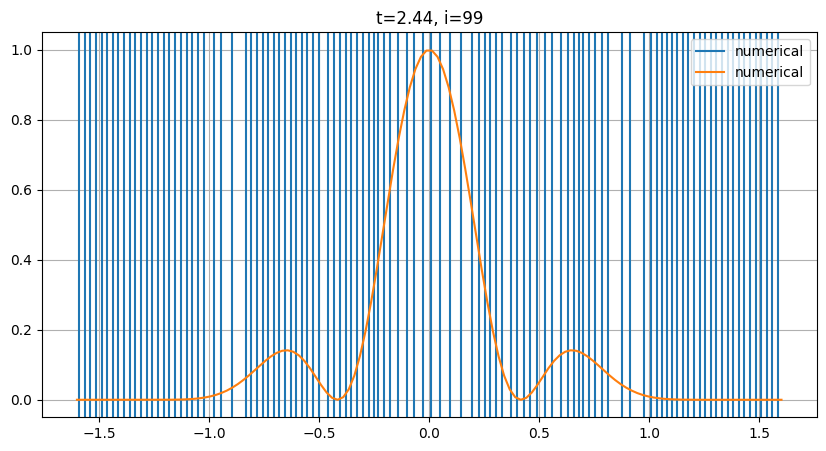

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

def init(): 
    axes.plot(xx,un[0,:], label="numerical")
    #axes.plot(xx,uu_analytic[0,:], label="analytic", linestyle="--")
    axes.legend()
    axes.set_ylim(-0.05, 1.05)
    axes.grid(True)
    
def animate(i):
    axes.clear()
    axes.plot(xx,un[i,:], label="numerical")
    #axes.plot(xx,uu_analytic[i,:], label="analytic",linestyle="--")
    axes.set_title('t={:.2f}, i={:g}'.format(tt[i],i))
    axes.grid(True)
    axes.legend()
    axes.set_ylim(-0.05, 1.05)

anim = FuncAnimation(fig, animate, interval=50, frames=nt, init_func=init)
HTML(anim.to_jshtml())

## 2 – Centered differences

Use now for the spatial derivation _centered finite differences_, i.e.:

$$\left(\frac{\partial u}{\partial x}\right)_{x=x_i} \rightarrow \frac{u_{i+1}-u_{i-1}}{2\Delta x}   \tag{2}$$

(and see the note on boundary conditions below). Fill in `nm_lib` the function `deriv_cent`, and like in the previous case, use the `lambda` function `ddx` and select the proper limits for `bnd_limits`. Use `cfl_cut=0.3`. Is any instability apparent in this case? Does the situation change when you change the sign of the constant $a$?

Note: In this case, the periodicity boundary condition can be implemented as follows: define $xx$ so that the endpoint $x = x_0$ of the domain coincides with $xx[1]$ (i.e., the second component of the array) and the endpoint $x = x_f$ coincides with the last element in the array [i.e., $xx[nump-1]$]. For the boundary condition, you can do the following: assume you are calling $uun$ the array at time $t + \Delta t$. Then the boundary condition is imposed by specifying $uun[0] = uun[nump-2]$ and $uun[nump-1] = uun[1]$.

## 3 – The stability of the non-centered finite-differences schemes

In the previous exercises, we saw that when $a > 0$, a _backward-oriented_ finite-difference scheme yields stability. However, a crucial component in the problem was to give a specific value for $\Delta t$, namely  $t = 0.98 x/|a|$. Would it have been wise to choose a larger or smaller $\Delta t$? Let us check that $\Delta t$ cannot be chosen arbitrarily large: run the program, but now writing

1. $\Delta t = 0.5 \frac{\Delta x}{a}$;
2. $\Delta t = 0.99 \frac{\Delta x}{a}$;
3. $\Delta t = 1.01 \frac{\Delta x}{a}$;
4. $\Delta t = 2 \frac{\Delta x}{a}$;

and check if those values maintain the good stability properties of the code. For example, does there seem to be a threshold in $\Delta t$ for the instability? Note that you need to define `cfl_cut` to 0.5, 0.99, 1.01, and 2.0.

## 4- Optional (A). 

Consider now the following Burgers’ equation, i.e.,

$$\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = 0   \tag{3}$$

can be seen as yet another case of the equation solved in the previous exercises of this
series by writing:

$$a(x,t,u) = u  \tag{4}$$

The importance of this equation in physics derives in part from the fact that it describes
the motion of a non-accelerated fluid with an arbitrary velocity field at time $t = 0$ and
because it contains the possibility of spontaneous formation of discontinuities. (\*)

We can simply solve equation (1) by modifying the program developed for the previous exercises but now writing $a(x_i, t^n) = u^n_i$. Carry out that modification, and run the program in the domain $x \in (x_0, x_f)$ with $x_0 = −1.4$, $x_f = 2.0$ with the initial condition:

$$u(x,t=0) = A\left[\tanh\left(\frac{x+x_c}{W}\right)-\tanh\left(\frac{x-x_c}{W}\right) \right] + B \tag{5}$$

whereby $A = 1.0$, $x_c = 0.70$, $W = 0.1$, $B = 0.3$. Let the solution evolve until time $t_f = 100$. Explain in physical (or mathematical) terms the solution you get. Change to $A = −0.02$ and explain the result. For this exercise, fill in `nm_lib` functions `evolv_uadv_burgers` and `step_uadv_burgers`. 

### Comments:

In the numerical solution, we see the initial condition patently evolving into something that looks like a discontinuity. We understand that this discontinuity is formed because the characteristic curves $dx_p/dt = a(x, t, u) = u$ are more inclined (i.e., faster) in a spacetime diagram when starting at elements with larger $u$: since the solution is constant along those curves, the faster elements, therefore, catch those in front of them which have lower $u$ (as is the case in the solution you have found numerically here) – so the solution must steepen when that happens.

Mathematically and physically, we should not be too surprised: we know that, for instance, in gas dynamics, weird nonlinear phenomena take place, some of which (the shocks) have to do with the formation of discontinuities or sharp transitions. Numerically, though, we ought to be rather surprised for various reasons:
    
a. the numerical calculation of a very large value of the derivative (as is surely the case across the big jump forming in our calculation) cannot be very accurate. It might even happen, we think, that the program crashed because of _NaNs_ or exceptions, etc, occurring in the calculation. But, in fact, our program happily calculates away ... seemingly forever.

b. when a discontinuity forms, the exact mathematical solution, strictly speaking, cannot be calculated in a simple way anymore: when there is a discontinuity, one must take into account what is called the jump relations, also called internal boundary conditions, across the discontinuity: they give the mutual relation of the variables on either side of the discontinuity. A solution obtained in this way is called a __weak solution__ in mathematics.

c. we finally ask ourselves what the mathematically-exact weak solution would be in this case and whether our simple numerical scheme provides a solution near the exact one despite the obvious difficulty of handling large jumps across the near-discontinuity.

We have to leave these as open questions for discussion at a later point. 

As a final comment, consider the consequences of the fact that the acceleration in gas dynamics contains a term of the general form $u$ $du/dx$ .... Much of the beautiful physics occurring in the universe is due to non-linearities like this one.

## 4- Optional (B) 

For this exercise, do first [ex_4a](https://github.com/AST-Course/AST5110/blob/main/ex_4a.ipynb). 
Consider the same setup as the previous exercise. But now, solve it using the upwind method: 

$$u^{n+1}_j = u^{n}_j - \frac{\Delta t}{\Delta x} u^{n}_j(u^{n}_j- u^{n}_{j+1})$$

And using the Lax method implemented in [ex_4a](https://github.com/AST-Course/AST5110/blob/main/ex_4a.ipynb). What do you see? Argue why you think the solution is not correct. __Hint__ In the first exercise, we disccused about flux conservation.

### Comments:
    
See [Stagger mesh](https://github.com/AST-Course/AST5110/wiki/Staggered-mesh) documentation on how a staggered mesh allows keeping the conservation. 